Introduction to the VSOP2013 planetary theory
==========

Starting from version 0.15, heyoka.py provides an implementation of the [VSOP2013](https://en.wikipedia.org/wiki/VSOP_%28planets%29) planetary theory. VSOP2013 consists of a set of (large) analytical formulae which calculate the heliocentric orbital elements of the 8 planets of the Solar System (plus the dwarf planet Pluto) as a function of time. Because the VSOP2013 theory is expressed as a set of analytical, differentiable formulae, it can be implemented in heyoka.py's expression system and it can thus be used in the formulation of differential equations.

API overview
-------

heyoka.py provides three functions to generate the analytical formulae for the VSOP2013 theory.

The first one, ``vsop2013_elliptic()``, returns the formulae for the heliocentric elliptic orbital elements for a given planet. The 6 elliptic orbital elements are, in order:

* the semi-major axis $a$ (in astronomical units),
* the [mean longitude](https://en.wikipedia.org/wiki/Mean_longitude) $\lambda$ (in radians),
* $k=e\cos\varpi$ and $h=e\sin\varpi$, where $e$ is the eccentricity and $\varpi=\Omega+\omega$ is the [longitude of the perihelion](https://en.wikipedia.org/wiki/Longitude_of_the_periapsis),
* $q=\sin\frac{i}{2}\cos\Omega$ and $p=\sin\frac{i}{2}\sin\Omega$, where $i$ is the inclination and $\Omega$ is the longitude of the ascending node.

This function requires as input the planet index (from 1 to 9) and the orbital element index (from 1 to 6). The orbital elements are referred to the inertial frame defined by the dynamical equinox and ecliptic J2000. Note that the VSOP2013 solution for the Earth (planet index 3) actually refers to the Earth-Moon barycentre.

The second function, ``vsop2013_cartesian()``, returns the heliocentric Cartesian state vector $\left( x, y, z, v_x, v_y, v_z \right)$ for a given planet. The Cartesian state is computed via a direct conversion of the orbital elements returned by ``vsop2013_elliptic()``, and thus it also refers to the inertial frame defined by the dynamical equinox and ecliptic J2000.

The third function, ``vsop2013_cartesian_icrf()``, returns the heliocentric Cartesian state vector for a given planet in the [International Celestial Reference Frame (ICRF)](https://en.wikipedia.org/wiki/International_Celestial_Reference_System_and_Frame). The ICRF state vector is computed by applying a rotation to the output of ``vsop2013_cartesian()``.

Precision and truncation threshold
--------

The VSOP2013 solution is formulated as large Fourier/Poisson series whose numerical coefficients decay exponentially. When using the full VSOP2013 solution, the precision with respect to high-accuracy numerical integrations is roughly sub-meter for the inner planets (except Mars) and kilometers for the outer planets (except Pluto). By dropping the smaller terms from the series, the precision of the theory degrades but computational efficiency greatly increases. See the [VSOP2013 readme](https://ftp.imcce.fr/pub/ephem/planets/vsop2013/solution/README.pdf) for more details and estimates of the precision at various truncation levels.

By default, all ``vsop2013_*()`` functions filter out from the solution terms whose numerical coefficients have a magnitude smaller than $10^{-9}$. The truncation threshold can be changed via the ``thresh`` keyword argument:

In [1]:
import heyoka as hy

for thr in [1e-7, 1e-9, 1e-11]:
    print("String length of Mars' semi-major axis solution @ {}: {}".format(thr, len(str(hy.vsop2013_elliptic(4, 1, thresh = thr)))))

String length of Mars' semi-major axis solution @ 1e-07: 49001
String length of Mars' semi-major axis solution @ 1e-09: 488373
String length of Mars' semi-major axis solution @ 1e-11: 4760576


Time coordinate
-----

The precision of the VSOP2013 solution is highest betwen $1890\,\mathrm{CE}$ and $2000\,\mathrm{CE}$, and it slowly degrades outside this time range. See the [VSOP2013 readme](https://ftp.imcce.fr/pub/ephem/planets/vsop2013/solution/README.pdf) for estimates of the precision degradation up to a few thousand years in the past/future.

VSOP2013 uses [barycentric dynamical time (TDB)](https://en.wikipedia.org/wiki/Barycentric_Dynamical_Time), expressed in thousands of Julian years from J2000 (JD2451545.0). Note than one Julian year = 365250 days.

By default, all ``vsop2013_*()`` functions use ``hy.time`` to represent the time variable in the VSOP2013 formulae. This means that, by default, when the VSOP2013 solution is used in an ODE system, time is assumed to be measured in thousands of Julian years of TDB and $t = 0$ corresponds to the Julian date $2451545.0$.

It is possible to change the expression used to represent the time variable in the VSOP2013 solution via the ``time`` keyword argument. This allows, for instance, to rescale and change the origin of time in the VSOP2013 formulae. Let us see a few examples:

In [2]:
print("Mars' semi-major axis solution, threshold = 6e-5, default time expression:\n{}\n".format(hy.vsop2013_elliptic(4, 1, thresh = 6e-5)))
print("Mars' semi-major axis solution, threshold = 6e-5, time represented by variable 'x':\n{}\n".format(hy.vsop2013_elliptic(4, 1, time=hy.expression("x"), thresh = 6e-5)))
print("Mars' semi-major axis solution, threshold = 6e-5, time rescaled by a factor of 100:\n{}".format(hy.vsop2013_elliptic(4, 1, time=hy.time / 100., thresh = 6e-5)))

Mars' semi-major axis solution, threshold = 6e-5, default time expression:
(1.5236793402339999 + ((2.1017753733317330e-07 * sin(((2.0000000000000000 * (6.2035000141410004 + (3340.6124341454570 * t))) + (-2.0000000000000000 * (0.59954610703500000 + (529.69096156232501 * t)))))) + (6.6017042784613703e-05 * cos(((2.0000000000000000 * (6.2035000141410004 + (3340.6124341454570 * t))) + (-2.0000000000000000 * (0.59954610703500000 + (529.69096156232501 * t))))))))

Mars' semi-major axis solution, threshold = 6e-5, time represented by variable 'x':
(1.5236793402339999 + ((2.1017753733317330e-07 * sin(((2.0000000000000000 * (6.2035000141410004 + (3340.6124341454570 * x))) + (-2.0000000000000000 * (0.59954610703500000 + (529.69096156232501 * x)))))) + (6.6017042784613703e-05 * cos(((2.0000000000000000 * (6.2035000141410004 + (3340.6124341454570 * x))) + (-2.0000000000000000 * (0.59954610703500000 + (529.69096156232501 * x))))))))

Mars' semi-major axis solution, threshold = 6e-5, time rescaled b

Checking the implementation
-----

In order to check the correctness of heyoka.py's implementation of the VSOP2013 theory, we are going to use the [NASA HORIZONS service](https://ssd.jpl.nasa.gov/?horizons) via the [Astroquery](https://astroquery.readthedocs.io/en/latest/) package. Our objective is to compare the planetary positions computed by VSOP2013 at different threshold levels with those computed by HORIZONS.

On the heyoka.py side, we will have to perform the computation of the planetary positions in a bit of a roundabout way. Specifically, given an explicit time-dependent formula $x_p\left( t \right)$ produced by VSOP2013 for, say, the $x$ coordinate of a planet, we will formulate an ODE of type

$$
\frac{ds}{d\tau} = x_p\left( \alpha \right),
$$

where $s$ is a dummy variable, and the time $t$ has been replaced with a constant $\alpha$ in the formula for $x_p$. Because $x_p\left( \alpha \right)$ is now a constant, the solution of this ODE is simply $s\left( \tau \right) = s_0 + x_p\left( \alpha \right)\tau$. By setting $s_0 = 0$ and $\alpha$ to the time coordinate at which we want to evaluate $x_p$, propagating the state of $s$ up to $\tau=1$ will produce an evaluation of $x_p\left( t \right)$ at the desired time coordinate. A horrible hack, but it works :)

In this example, we will be using Venus as a target body. Because the ecliptical coordinate system used by VSOP2013 does not match exactly any of the coordinate systems available in HORIZONS, we will be using the ``vsop2013_cartesian_icrf()`` function instead, which outputs heliocentric Cartesian coordinates in the standard [ICRF](https://en.wikipedia.org/wiki/International_Celestial_Reference_System_and_Frame) (which is available in HORIZONS). Let's take a look at the code and at the results:

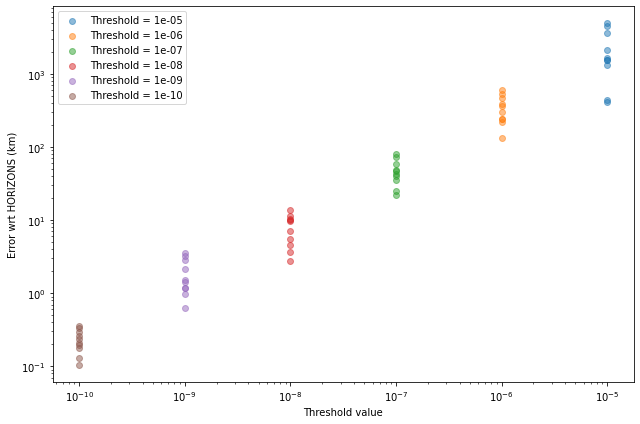

In [3]:
%matplotlib inline
from matplotlib.pylab import plt
import numpy as np
from astroquery.jplhorizons import Horizons
from copy import deepcopy

# Setup the plot.
fig = plt.figure(figsize=(9, 6))
plt.xscale('log')
plt.yscale('log')

# Create the heyoka variables.
x, y, z = hy.make_vars("x", "y", "z")

# Threshold levels at which we will be computing
# the VSOP2013 solution.
thr_values = [1e-5, 1e-6, 1e-7, 1e-8, 1e-9, 1e-10]

# We will perform 10 evaluations of the
# position of Venus in the 10 years following
# J2000.
dates = [2451545.0 + _ * 365 for _ in range(10)]

for thr in thr_values:
    # Build the VSOP2013 formulae for the heliocentric Cartesian
    # position of Venus (planet index 2) in the ICRF. Replace the
    # default time variable with a runtime parameter and set
    # a custom threshold level.
    venus_x, venus_y, venus_z = hy.vsop2013_cartesian_icrf(2, time=hy.par[0], thresh=thr)[:3]

    # Build the dummy integrator which we will use to compute
    # the VSOP2013 solution in heyoka.py.
    ta = hy.taylor_adaptive([(x, venus_x), (y, venus_y), (z, venus_z)], [0.]*3, compact_mode=True)

    vsop_states = []

    for date in dates:
        # Reset the integrator state.
        ta.time = 0
        ta.state[:] = 0
        # Assign the time at which we want to
        # evaluate the VSOP2013 solution.
        # NOTE: the default time coordinate
        # for VSOP2013 is thousands of Julian
        # years from J2000.
        ta.pars[0] = (date - 2451545.0) / 365250 
        
        # Do the evaluation.
        ta.propagate_until(1)
        
        # Append the computed Venus position.
        vsop_states.append(deepcopy(ta.state))
   
    vsop_states = np.array(vsop_states)

    # HORIZONS query:
    # - 299 is the ID of Venus,
    # - 500@10 is the observer's location,
    #   the centre of the Sun.
    q = Horizons('299', id_type='majorbody', location='500@10',
                 epochs=dates)
    # Convert the HORIZONS query to the ICRF
    # and extract the cartesian position vector.
    tab = q.vectors(refplane='earth')
    hor_x = tab['x'].quantity[:].value
    hor_y = tab['y'].quantity[:].value
    hor_z = tab['z'].quantity[:].value
    
    hor_states = np.array([hor_x, hor_y, hor_z]).transpose()

    # Plot the difference (in km) between the position computed
    # by VSOP2013 and HORIZONS.
    plt.scatter([thr]*len(vsop_states), np.linalg.norm(vsop_states - hor_states, axis=1) * 1.496e8,
               alpha=.5, label="Threshold = {}".format(thr))

# Finish setting up the plot.
plt.legend()
plt.xlabel("Threshold value")
plt.ylabel("Error wrt HORIZONS (km)")
plt.tight_layout();

We can see how VSOP2013 matches up well with respect to HORIZONS, and how lower truncation levels indeed increase the precision of the VSOP2013 solution (up to an error of hundreds of meters for a threshold of $10^{-10}$).

Limitations and caveats
-----

A possible issue in astrodynamical applications is that VSOP2013 does not directly provide formulae for the state vector of the Sun. The barycentric position of the Sun can be estimated via the heliocentric planetary formulae after imposing that the system's barycentre is fixed in the origin. It is not clear at this time if this approach is 100% accurate (as VSOP2013 includes perturbations on the planets by asteroids, whose state vectors are not provided in the solution), but it should be adequate for most practical purposes.